<a href="https://colab.research.google.com/github/Kanton99/QPU_NN_Project/blob/main/final_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quaternion Product Units for Deep Learning on 3D Rotation Groups

Student names : Anton Volkov (Matricola) & Keerthana Kumaresan (1998292)

The paper chosen is about using quaternion, quaternion algebra and the law of 3D rotation groups instead of Euclidean methods to create a mechanism to enhance the robustness of deep learning models to rotation. The proposed Quaternion Prouduct Unit represent the data as 3D pure quaternions (with the scalar being zero) and merges them through weighted chain of Hamilton products.

$$
q= s + ix + jy +kz ⊂ \mathbb{H}
$$

where we have 1D real part and 3D imaginary part

 Such is used so we would be able to derive the "Rotation Invariant" and "Rotation Equivarient" features.

$$
\mathbf{Rotation-invariance}: \space f(R(x)) = f(x), \forall x \in X \\
\mathbf{Rotation-eqivariance}: \space f(R(x)) = R(f(x)), \forall x \in X \\
$$

$x = [x_{1}, ...,x_{N}] \in X$ contains $N$ rotations. The above feature support and improve the efficency in theory. The suggested QPU is implemented in a quaternion neural network and is made compatible with existing  deep learning models.

### QPU

Each quaternion is represented as a unit quaternion, where the imaginary part gives the direction of its rotaion axis and the real part corresponds to the cosine of its rotation angle.

$q_{out} = [s_{out},v_{out}] \in \mathbb{H}$ where the outputs gives us the rotation invariant and eqivariant part.

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=15XPVmukWbq1-_dwH_UeokPYvoAsY_9e5' width = 70%/>
</figure>

We represent the quaternion removing the imaginary parts.

\begin{equation}
q = [s, \mathbf{v}] = [s, (x,y,z)]
\end{equation}

The Hamilton product between two quaternions $q_{1} = [s_{1}, \mathbf{v_{1}}]$ and $q_{2} = [s_{2}, \mathbf{v_{2}}]$ is defined as

\begin{equation}
q_{1} ⊗ q_{2} = [s_{1}s_{2} - (\mathbf{v_{1}} \cdot \mathbf{v_{2}}), \mathbf{v_{q}} \times \mathbf{v_{2}} + s_{1}\mathbf{v_{2}} +  s_{2}\mathbf{v_{1}}]
\end{equation}

we must note that the hamilton product is not commutative, the the order of rotations matter when implementing it. If we rotate a 3D vector $\mathbf{v_{1}}$ to another 3D vector $\mathbf{v_{2}}$ and the rotation is with the axis $\mathbf{u}$ and angle $\theta$ then we define a unit quaternion as

\begin{equation}
q = [s, \mathbf{v}] = [cos\left(\frac{\theta}{2}\right),sin\left(\frac{\theta}{2}\right) \mathbf{u}]
\end{equation}

where $\lVert \mathbf{u} \rVert_{2} = 1$ and $s^2 + \lVert \mathbf{v} \rVert_{2}^2 = cos^2\left(\frac{\theta}{2}\right),sin^2\left(\frac{\theta}{2}\right) =1$. The vectors $\mathbf{v_{1}}$ and $\mathbf{v_{2}}$ as pure quaternions $[0, \mathbf{v_{1}}]$ and $[0, \mathbf{v_{2}}]$

\begin{equation}
q = [0, \mathbf{v_{2}}] = q \otimes [0, \mathbf{v_{1}}] \otimes q^*
\end{equation}

The $q^* = [0, \mathbf{-v}]$ is the conjugate of $q$.

The combination of rotation matrices can also be denoted as such with Hamilton products.

\begin{equation}
(q_{2} \otimes q_{1})  \otimes [0, \mathbf{v_{1}}] \otimes (q^*_1 \otimes q^*_2)
\end{equation}


### MODELS

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1M6_beQ3FZhl5GOWJRUZuQpNo_e_uHDp9' width = 70%/>
</figure>

We are replacing the neurons in a standard deep learning model with weighted chain of Hamilton product. Usually the neurons are represented as a weighted summation unit where there are learnable parameters, inputs and a non linear activation function.

A problem with the quaternion proposed above is that it does not guarantee the closer of $\mathbb{SO}(3)$ so we make them weighted and it is defined as such, for $N$ unit quaternions, the product is

\begin{equation}
y = \bigotimes^N_{i=1} q^{w_{i}}_i = q_1^{w_{1}} \otimes q_2^{w_{2}} \otimes ... \otimes q_N^{w_{N}}
\end{equation}

The power of the quaternion is defined in the paper but for simplification has not been included here but this is being implemented in the code. One important note is that the power of the quaternion only scales the rotation angle but does not change the rotation axis.

\begin{equation}
QPU(\{q_i\}^N_{i=1}; \{ w_i\}_{i=1}^N,b) = \bigotimes^N_{i=1} qpow(q_i;w_i, b)
\end{equation}

where for $q_i =[s_i,\mathbf{v_i}]$  and  \\
$qpow(q_i;w_i, b) = [cos(w_i(arcos(s_i) + b)), \frac{\mathbf{v_i}}{\lVert \mathbf{v_i}\rVert_2} sin (w_i(arcos(s_i) +b))]$ represents the weights $w_i$ and a bias $b$.

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1lmSkoOiFs_epW09DQaGHxVPEJJ2C5b78' width = 70%/>
</figure>

The multiple QPUs recieving the input  quaternions for a FC-layer. Since the QPU itself is nonlinear in nature, we have no activation function added. The output of a QPU is a quaternion, so we connect multiple QPU-based FC layers to form a Quaternion Multi-Layer Perceptron (QMLP) model.

Three models are shown in the picture above, where one has already been explain and the QMLP-RInv is a variant of QMLP and RMLP is the standard real-valued MLP. All the models consists of three layer.





### DATASET GENERATION

#### CUBE EDGE

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1-uN02rj6LpVbLVWzMlnPddkOEztP7Mas' width = 70%/>
</figure>

A dataset is generated to test the robustness of our QPU based models. The dataset consits of partial skeletons of an cube. The number of edges is selected first and the in the exam we have a used 4, 5, 6 and 7 number of edges. and as the edges increase the data samples increase. To be concise on how the datset is derived, an edge is considered and depending on the number of edges chosen, one of the adjacent edge of the previous edge is chosen to for a skeleton. Samples can be seen in the above picture and a set of sample are plotted at the end of the code.


### TRAIN AND TEST

#### Backpropagation of QPU

Computing the gradient of the weighting function are easy but the gradient of the Hamilton product chain is not simple. The diffrential of the quaternion is calculated and this is explained more detailed in the paper but has been excluded here.

The computation of  the differential of loss $L$ for the quaternion is done (computed with autograd in Pytorch).

In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import time

import sys
sys.path.append('.')


from CubeEdge.models import *
from CubeEdge.train import *

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-s_c9pl8q because the default path (/home/sakura/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
device = (
        "cuda" if torch.cuda.is_available()
        else "mps" if torch.backends.mps.is_available()
        else "cpu"
    )

epochs = 100

Datasets generation

In [4]:
training_data = CubeEdge(train=True, num_edges=7, use_quaternion=True,num_samples=500)
test_data = CubeEdge(train=False,num_edges=7,use_quaternion=True,num_samples=50)

Plots generatioon function

In [21]:
def plot_loss(loss):
    plt.plot(loss)
    plt.title("Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

QMLP_RInv training and testing

In [24]:
start_time = time.time()
net = QMLP_RInv(num_data=7,num_cls=training_data.num_shapes)
print("Network being trained is QMLP_RInv")
qmlp_rinv_train_loss = train(model=net,data=training_data,epochs=epochs,lr=0.01,batch_size=training_data.num_shapes)
print("Training is completed")
print("--- %s seconds ---" % (time.time() - start_time))

Network being trained is QMLP_RInv
epoch: 10
loss:  tensor(0.3759, grad_fn=<NllLossBackward0>)
epoch: 20
loss:  tensor(0.9107, grad_fn=<NllLossBackward0>)
epoch: 30
loss:  tensor(0.3118, grad_fn=<NllLossBackward0>)
epoch: 40
loss:  tensor(0.4384, grad_fn=<NllLossBackward0>)
epoch: 50
loss:  tensor(0.1890, grad_fn=<NllLossBackward0>)
epoch: 60
loss:  tensor(0.1414, grad_fn=<NllLossBackward0>)
epoch: 70
loss:  tensor(0.1772, grad_fn=<NllLossBackward0>)
epoch: 80
loss:  tensor(0.4232, grad_fn=<NllLossBackward0>)
epoch: 90
loss:  tensor(0.3552, grad_fn=<NllLossBackward0>)
epoch: 100
loss:  tensor(0.3657, grad_fn=<NllLossBackward0>)
Training is completed
--- 76.55676603317261 seconds ---


In [6]:
test(model=net,data=test_data)

Test Error: 
 Accuracy: 56.0%, Avg loss: 2.218980 



[2.197718381881714, 2.240241527557373]

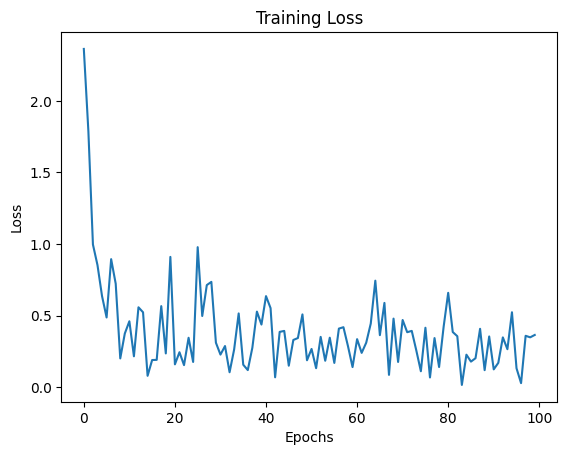

In [25]:
plot_loss(qmlp_rinv_train_loss)
plt.show()

QMLP Training and testing

In [26]:
# Train QMLP
start_time = time.time()
net = QMLP(num_data=7,num_cls=training_data.num_shapes)
print("Network being trained is QMLP")
qmlp_train_loss = train(model=net,data=training_data,epochs=epochs,lr=0.01,batch_size=training_data.num_shapes)
print("Training is completed")
print("--- %s seconds ---" % (time.time() - start_time))


Network being trained is QMLP
epoch: 10
loss:  tensor(0.5562, grad_fn=<NllLossBackward0>)
epoch: 20
loss:  tensor(0.4196, grad_fn=<NllLossBackward0>)
epoch: 30
loss:  tensor(0.2477, grad_fn=<NllLossBackward0>)
epoch: 40
loss:  tensor(0.0776, grad_fn=<NllLossBackward0>)
epoch: 50
loss:  tensor(0.2200, grad_fn=<NllLossBackward0>)
epoch: 60
loss:  tensor(0.4213, grad_fn=<NllLossBackward0>)
epoch: 70
loss:  tensor(0.4370, grad_fn=<NllLossBackward0>)
epoch: 80
loss:  tensor(0.2052, grad_fn=<NllLossBackward0>)
epoch: 90
loss:  tensor(0.2798, grad_fn=<NllLossBackward0>)
epoch: 100
loss:  tensor(0.5332, grad_fn=<NllLossBackward0>)
Training is completed
--- 54.52443599700928 seconds ---


In [28]:
test(model=net,data=test_data)

Test Error: 
 Accuracy: 88.0%, Avg loss: 0.246498 



[0.17950592935085297, 0.3134895861148834]

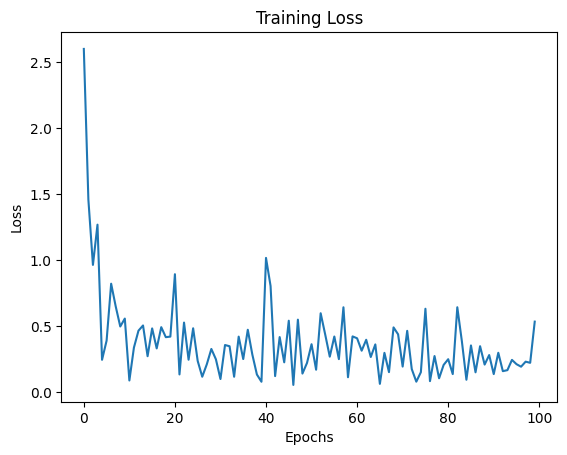

In [27]:
plot_loss(qmlp_train_loss)
plt.show()

RMLP Training and testing

In [19]:
start_time = time.time()
net = RMLP(num_data=7,num_cls=training_data.num_shapes)
print("Network being trained is RMLP")
train_loss = train(model=net,data=training_data,epochs=epochs,lr=0.01,batch_size=training_data.num_shapes)
print("Training is completed")
print("--- %s seconds ---" % (time.time() - start_time))

Network being trained is RMLP
epoch: 10
loss:  tensor(0.5840, grad_fn=<NllLossBackward0>)
epoch: 20
loss:  tensor(0.8733, grad_fn=<NllLossBackward0>)
epoch: 30
loss:  tensor(0.3081, grad_fn=<NllLossBackward0>)
epoch: 40
loss:  tensor(0.2571, grad_fn=<NllLossBackward0>)
epoch: 50
loss:  tensor(0.3680, grad_fn=<NllLossBackward0>)
epoch: 60
loss:  tensor(0.1568, grad_fn=<NllLossBackward0>)
epoch: 70
loss:  tensor(0.2941, grad_fn=<NllLossBackward0>)
epoch: 80
loss:  tensor(0.4708, grad_fn=<NllLossBackward0>)
epoch: 90
loss:  tensor(0.1475, grad_fn=<NllLossBackward0>)
epoch: 100
loss:  tensor(0.3761, grad_fn=<NllLossBackward0>)
Training is completed
--- 47.26086091995239 seconds ---


In [18]:
test(model=net,data=test_data)

Test Error: 
 Accuracy: 88.0%, Avg loss: 0.434894 



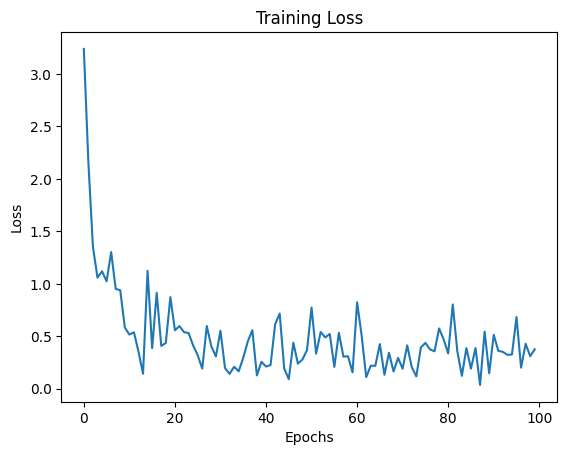

In [20]:
plot_loss(train_loss)
plt.show()